In [1]:
import pandas as pd 
from scipy.stats import spearmanr
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 


## Some Globals

In [2]:
# Defining some global stuff
filepath = 'Data/SP500.csv'
full_df = pd.read_csv(filepath)
full_df['Date'] = pd.to_datetime(full_df['Date'], utc=True)

sp500_tickers = full_df['Symbol'].unique().tolist() 
# We can't include these tickers because the were not present in the S&P500 for our entire timeframe
exclude = ['BRK.B', 'BF.B', 'ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOXA', 'FOX', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO']
sp500_tickers = [ticker for ticker in sp500_tickers if ticker not in exclude]

## Network Construction

In [3]:
# Using 1 / correlation for weight
def create_base_network(corr_coef, corr_matrix, sp500_tickers):
    '''
        corr_coef: float 0 to 1
        corr_matrix: pandas df from get_corr_matrix
        sp500_tickers: python list of ticker symbols
    '''
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        G.add_node(stock) 
        
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            
            # Check if the stock symbols are present in the correlation matrix

            # CHANGED CORRELATION THRESHOLD TO THIS IF BLOCK
            if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
                correlation_coefficient = corr_matrix.loc[stock1, stock2]
                if not np.isnan(correlation_coefficient) and abs(correlation_coefficient) > corr_coef:
                    G.add_edge(stock1, stock2, weight= 1 / correlation_coefficient)
    return G

# Using 1 / correlation for weight
def create_sector_network(corr_coef, corr_matrix, sp500_tickers, sector_df, valid_sectors_array):
    '''
        corr_coef: float 0 to 1
        corr_matrix: pandas df from get_corr_matrix
        sp500_tickers: python list of ticker symbols
        sector_df: pandas df of ['Symbol'] and ['GICS Sector'] from get_sector_df
        valid_sectors_array: python list of strings of sectors to include in network
    '''
    #create graph 
    G = nx.Graph() 

    for stock in sp500_tickers: 
        if stock in sector_df['Symbol'].values:
            sector = sector_df.loc[sector_df['Symbol'] == stock, 'GICS Sector'].iloc[0]
            if sector in valid_sectors_array:
                G.add_node(stock, sector = sector) 
        
    node_list = list(G.nodes())
    #add links 
    for i in range(len(sp500_tickers)): 
        for j in range(i + 1, len(sp500_tickers)):
            stock1 = sp500_tickers[i]
            stock2 = sp500_tickers[j]
            # Check if the stock symbols are present in the correlation matrix
            if (stock1 not in node_list) or (stock2 not in node_list):
                continue
            # CHANGED CORRELATION THRESHOLD TO THIS IF BLOCK
            if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
                correlation_coefficient = corr_matrix.loc[stock1, stock2]
                if not np.isnan(correlation_coefficient) and abs(correlation_coefficient) > corr_coef:
                    G.add_edge(stock1, stock2, weight= 1 / correlation_coefficient)
    return G

# This function works for daily but not monthly
def dataframe_creation(time_step, start_date, end_date):
    '''
    time_step must be 'm' for months, 'd' for daily
    potentially can implement yearly
    start_date and end_date must be in 'yyyy-mm-dd' format
    '''
    # Read in all the stock data
    filepath = 'Data/SP500.csv'
    full_df = pd.read_csv(filepath)

    # Ensure all Dates are in proper format
    full_df['Date'] = pd.to_datetime(full_df['Date'], utc=True)
    start_date = pd.to_datetime(start_date, utc=True)
    end_date = pd.to_datetime(end_date, utc=True)

    ranged_df = full_df[(full_df['Date'] >= start_date) & (full_df['Date'] <= end_date)]
    ranged_df.dropna(subset=['Date'])

    if time_step == 'm':
        return get_monthly_df(ranged_df)

    if time_step == 'd':
        return ranged_df

    return 0

# THIS FUNCTION WORKS I THINK 
def get_monthly_df(passed_df):
    # Use boolean indexing to filter the DataFrame for the last day of each month
    
    #last_day = passed_df['Date'] + pd.offsets.MonthEnd(0)
    #last_day_df = passed_df[passed_df['Date'].isin(last_day)]

    # Reset the index if needed
    #last_day_df.reset_index(drop=True, inplace=True)
    
    #passed_df.sort_values(by='Date', inplace=True)
    #try:
        #monthly_last_price = passed_df.groupby('Symbol').resample('M', on='Date')['Close'].last()
    #except Exception as e:
        #print("Error occurred during grouping and resampling:", e)
    #monthly_last_price = monthly_last_price.reset_index()
    # print(len(last_day_df))
    # print(last_day_df.head())
    '''
        Takes in the original dataframe read by the csv
        Should only be called by dataframe_creation
    '''
    unique_stocks = passed_df['Symbol'].unique()
    #last_dates = pd.DataFrame(columns=['Symbol', 'Last_Date'])
    last_dates_data = []

    for stock in unique_stocks:
        stock_df = passed_df[passed_df['Symbol'] == stock]

        stock_df.sort_values(by='Date',inplace=True)
        stock_df['Year_Month'] = stock_df['Date'].dt.to_period('M')
        max_date_per_month = stock_df.groupby('Year_Month')['Date'].max()

        for year_month, last_date in max_date_per_month.items():
            last_dates_data.append({'Symbol': stock, 'Date': last_date})


    last_dates = pd.DataFrame(last_dates_data)

    #result = pd.merge(passed_df, last_dates, on='Date', how='inner')
    result = passed_df[passed_df['Date'].isin(last_dates['Date'])]


    return result

def get_corr_matrix(df):
    '''
    Takes in the full csv dataframe and returns spearman correlation matrix 
    '''
    return df.pivot(index='Date',columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

# Sectors are :
#   Industrials, Health Care, Information Technology, Utilities, Financials, Materials
#   , Real Estate, Communication Services, Consumer Staples, Consumer Discretionary
#   , Energy
def get_sector_df(df):
    '''
        Takes in the full dataframe read from csv and returns
        a dataframe consisting of symbols(unique) and sectors
    '''
    return_df = df[['Symbol', 'GICS Sector']]
    return_df = return_df.drop_duplicates(subset=['Symbol'])
    return_df = return_df.reset_index(drop=True)
    return return_df






# THIS NEEDS TO BE PROPERLY CITED TO EMMA TOWLSON
## Degree Distribution 

In [4]:
# THIS CODE NEEDS TO BE CITED TO EMMA TOWLSON
def plot_log_deg_dist(G, title):
    '''
        Takes in a graph as paramter
        title should be worded to fit with: 'Log-Log Degree Distribution of...'
        Will plot the log scale degree distribution
        IMPORTANT:
            If a graph has nodes with degree 0, this function will be inaccurate
            This function removes nodes with degree 0
        
    '''

    degrees = [G.degree(node) for node in G if G.degree(node) > 0]
    kmin = min(degrees)
    kmax = max(degrees)

    # Get 10 logarithmically spaced bins between kmin and kmax
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

    # histogram the data into these bins
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    fig = plt.figure(figsize=(6,4))

    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(f'Log-Log Degree Distribution of {title}')

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
  

    # Show the plot
    plt.show()

# THIS CODE NEEDS TO BE CITED TO EMMA TOWLSON
def plot_lin_deg_dist(G, title):

    '''
        Takes in a graph as paramter
        title should be worded to fit with: 'Linear Degree Distribution of...'
        Will plot the log scale degree distribution
        IMPORTANT:
            If a graph has nodes with degree 0, this function will be inaccurate
            This function removes nodes with degree 0
        
    '''
    degrees = [G.degree(node) for node in G if G.degree(node) > 0]
    kmin = min(degrees)
    kmax = max(degrees)
    # Get 20 logarithmically spaced bins between kmin and kmax
    bin_edges = np.linspace(kmin, kmax, num=10)

    # histogram the data into these bins
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    fig = plt.figure(figsize=(6,4))

    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.plot(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(f'Linear Degree Distribution of {title}')
    

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Show the plot
    plt.show()


## Driver Code

In [93]:
# start of data = "2019-01-01"
# end of data = "2023-12-31"
#   Industrials, Health Care, Information Technology, Utilities, Financials, Materials
#   , Real Estate, Communication Services, Consumer Staples, Consumer Discretionary
#   , Energy
all_sectors = ['Industrials', 'Health Care', 'Information Technology', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Energy']


testing_df = dataframe_creation('m', '2019-01-01', '2023-12-31')

testing_corr = get_corr_matrix(testing_df)
sector_df = get_sector_df(testing_df)

oil_graph = create_sector_network(0.7, testing_corr, sp500_tickers, sector_df, all_sectors) 

 
print("Length of Data: ", len(testing_df))
print("Sector Nodes: ", oil_graph.number_of_nodes())
print("Sector Edges: ", oil_graph.number_of_edges())


/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_5866/2947665764.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.sort_values(by='Date',inplace=True)
/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_5866/2947665764.py:120: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_df['Year_Month'] = stock_df['Date'].dt.to_period('M')
/var/folders/66/h03hhhb11t95f_pkzy7yrzm00000gn/T/ipykernel_5866/2947665764.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df['Year_Month'] = stoc

Length of Data:  29340
Sector Nodes:  489
Sector Edges:  2290


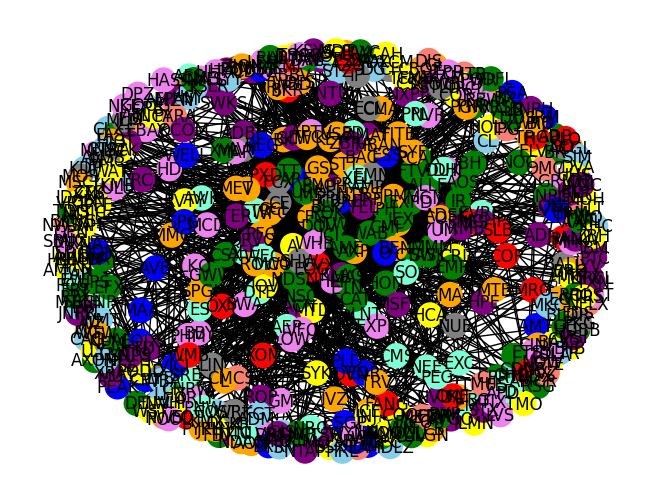

In [94]:
sector_colors = {
    'Energy':'red',
    'Real Estate': 'blue',
    'Industrials': 'green',
    'Health Care': 'yellow',
    'Information Technology': 'purple',
    'Utilities': 'aquamarine',
    'Financials': 'orange',
    'Materials': 'gray',
    'Communication Services': 'salmon',
    'Consumer Staples': 'skyblue',
    'Consumer Discretionary': 'violet',
}
pos = nx.spring_layout(oil_graph, k=1)
node_colors = [sector_colors[oil_graph.nodes[node]['sector']] for node in oil_graph.nodes()]
nx.draw(oil_graph,pos, labels={node: node for node in oil_graph.nodes()}, node_color=node_colors)

Name: Industrials
Sector Nodes:  74
Sector Edges:  248

Name: Health Care
Sector Nodes:  63
Sector Edges:  41

Name: Information Technology
Sector Nodes:  64
Sector Edges:  119

Name: Utilities
Sector Nodes:  29
Sector Edges:  148

Name: Financials
Sector Nodes:  71
Sector Edges:  429

Name: Materials
Sector Nodes:  26
Sector Edges:  28

Name: Real Estate
Sector Nodes:  31
Sector Edges:  72

Name: Communication Services
Sector Nodes:  20
Sector Edges:  4

Name: Consumer Staples
Sector Nodes:  36
Sector Edges:  15

Name: Consumer Discretionary
Sector Nodes:  52
Sector Edges:  56

Name: Energy
Sector Nodes:  23
Sector Edges:  108



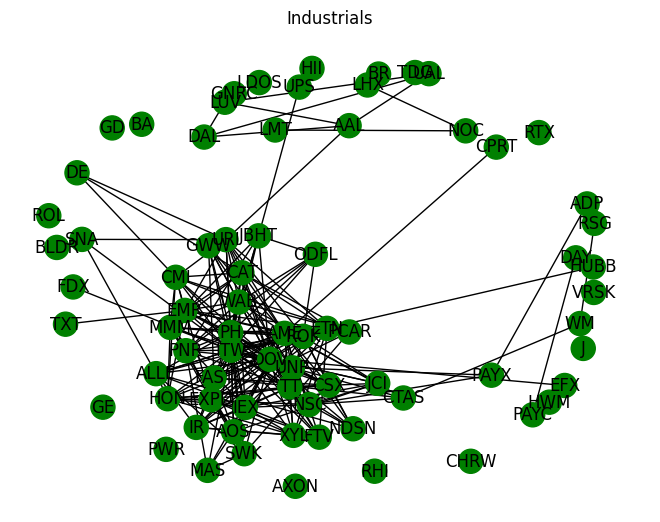

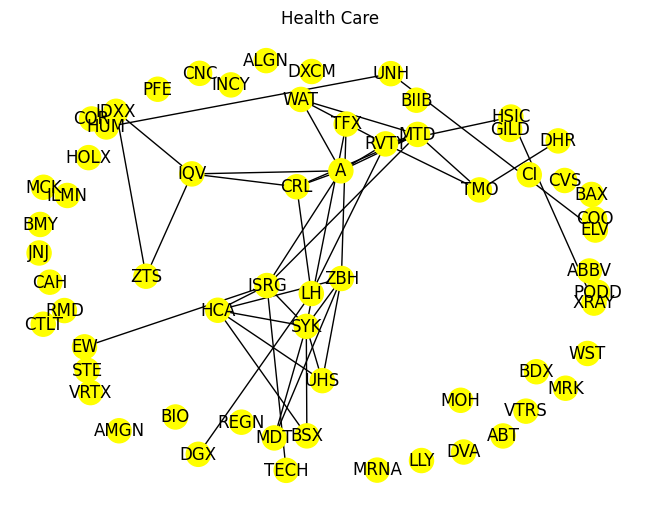

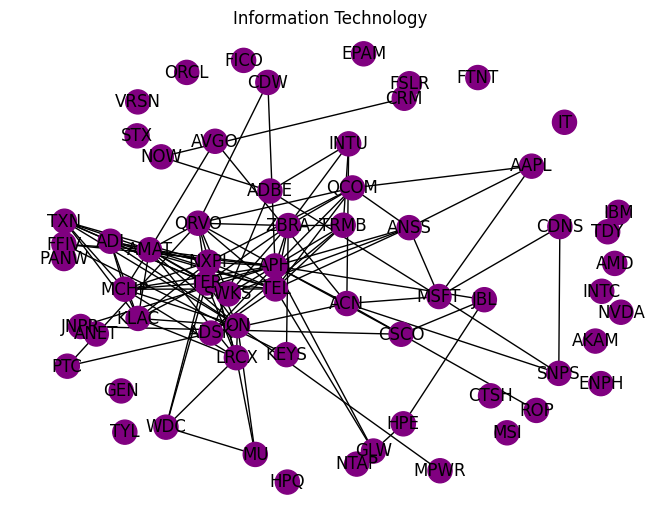

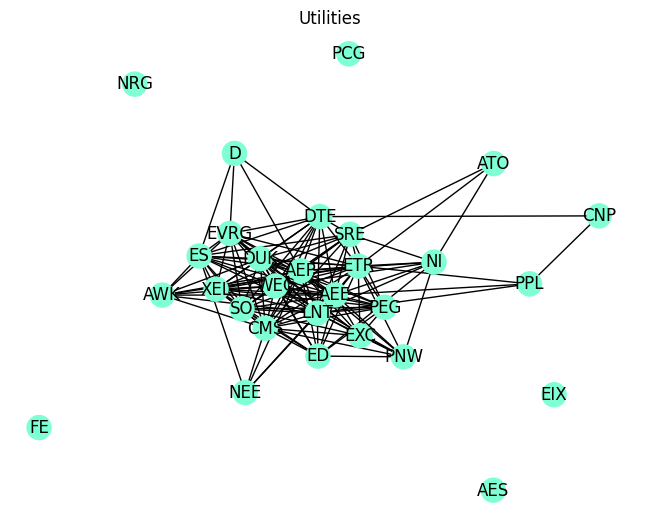

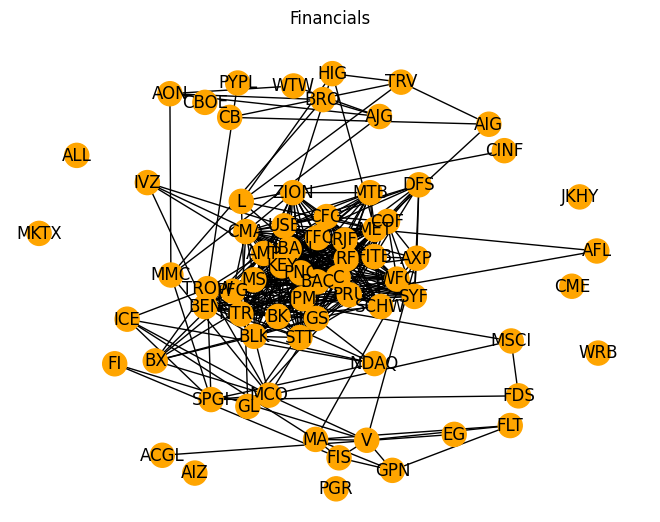

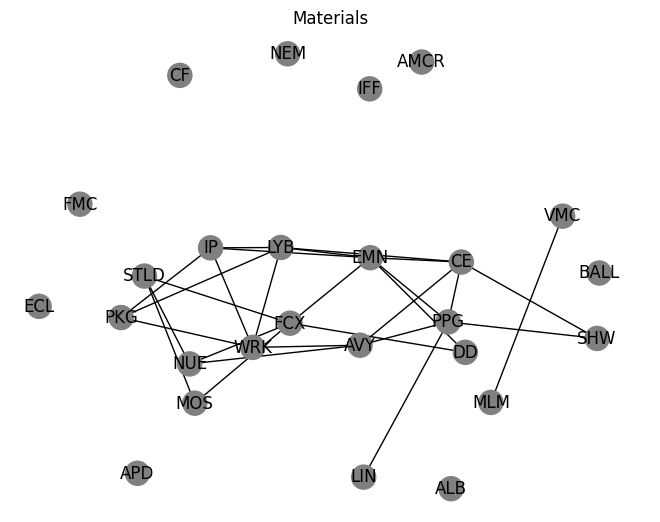

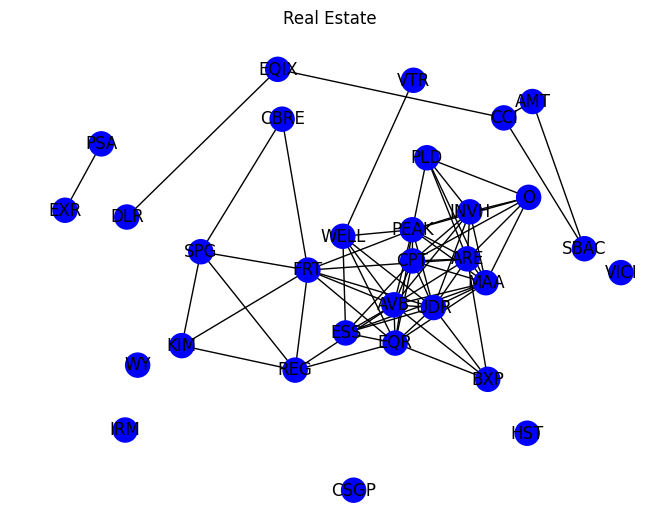

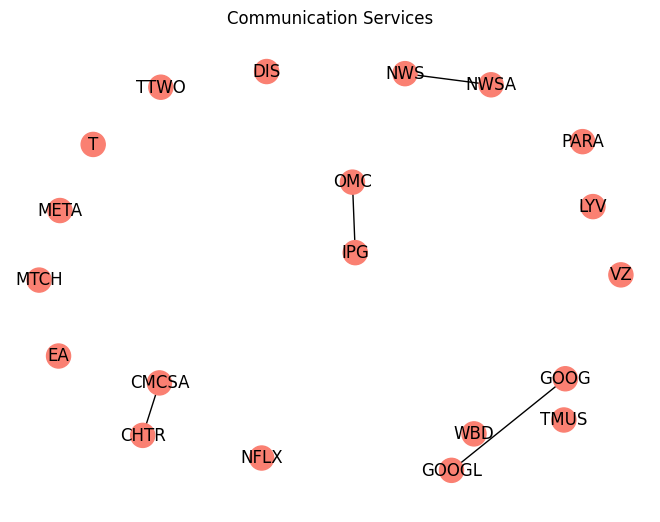

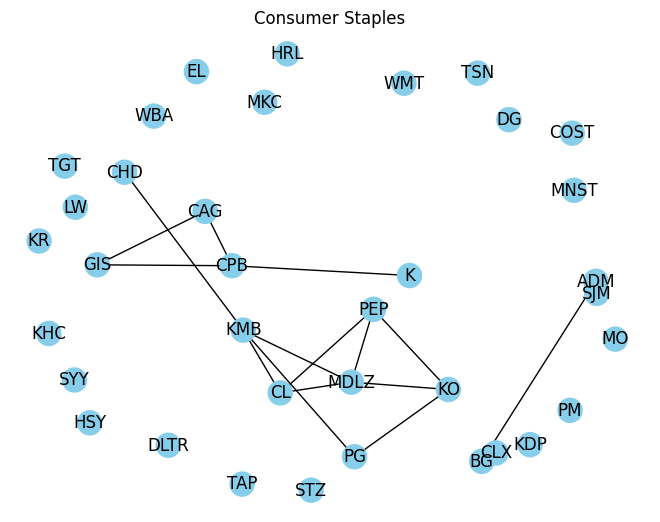

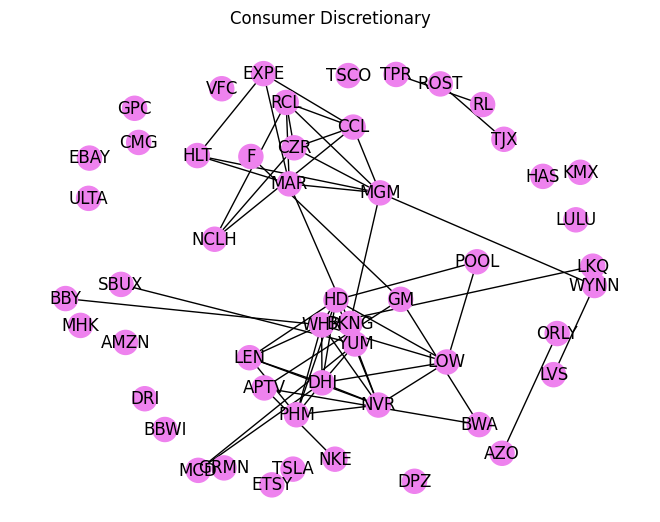

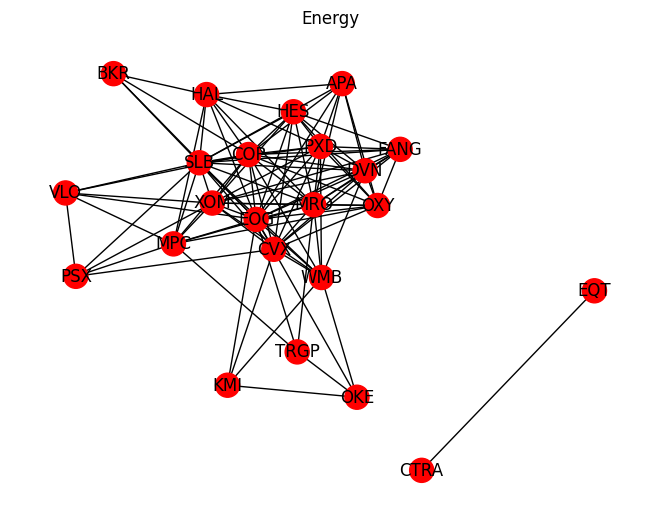

In [98]:

testing_corr = get_corr_matrix(testing_df)
sector_df = get_sector_df(testing_df)
g_mat = []
for name in all_sectors:
    oil_graph = create_sector_network(0.7, testing_corr, sp500_tickers, sector_df, [name]) 
    g_mat.append((oil_graph,name))
    #print("Length of Data: ", len(testing_df))
    print("Name:", name)
    print("Sector Nodes: ", oil_graph.number_of_nodes())
    print("Sector Edges: ", oil_graph.number_of_edges())
    print()


for pair in g_mat:
    graph = pair[0]
    pos = nx.spring_layout(graph, k=1)
    node_colors = [sector_colors[graph.nodes[node]['sector']] for node in graph.nodes()]
    nx.draw(graph,pos, labels={node: node for node in graph.nodes()}, node_color=node_colors)
    plt.title(pair[1])
    plt.show()
# print("Length of Data: ", len(testing_df))
# print("Sector Nodes: ", oil_graph.number_of_nodes())
# print("Sector Edges: ", oil_graph.number_of_edges())

In [57]:
#nx.write_gml(oil_graph, '0.7_m_2023_all_sector.gml')